# Comparisons with DIS

In [2]:

import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


import sklearn as skl
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from joblib import Parallel, delayed
from torch.nn.functional import pad

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = torch.as_tensor(x)
    y = torch.as_tensor(y)
    return sinkhorn(x,y)

def ot_dist(x,y):
    x = x.detach().numpy()
    y = y.detach().numpy()
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    distance = torch.tensor(ot.emd2(a,b,Mat))
    return distance

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [3]:
QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100


ginkgo_simulator = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)

# Set maxLeaves to 50.
ginkgo_simulator_clip = invMass_ginkgo.SimulatorModel(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=50,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True)


prior_min = [1e-2,1e-2]
prior_max = [10.,10.]
prior_full = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [4]:
obs_leaves = torch.tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
                        [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
                        [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
                        [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
                        [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
                        [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
                        [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
                        [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
                        [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
                        [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
                        [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
                        [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
                        [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
                        [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
                        [12.21401828,  6.76059035,  6.94920042,  7.42823701],
                        [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
                        [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
                        [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
                        [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
                        [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
                        [15.40023764,  9.10884407,  8.93836964,  8.61970667],
                        [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
                        [19.81054106, 11.90268453, 11.60989346, 10.76953856],
                        [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
                        [25.74331932, 15.63430056, 14.83860792, 14.07189108],
                        [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
                        [12.34604239,  7.78770185,  6.76075998,  6.78498685],
                        [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
                        [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
                        [16.28983576,  9.66683929,  9.24891886,  9.28970032],
                        [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
                        [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
                        [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
                        [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
                        [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]])



## Prepare functions

In [10]:
def single_dist_sim(params):
    leaves = ginkgo_simulator(params)['leaves']
    return ot_dist(leaves, obs_leaves).reshape(1)

In [11]:
def kernel(xs): # Doesn't work
    
    distances = xs
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x[:,0]**2/(var))
    
    return wrapped

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
 Neural network successfully converged after 77 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

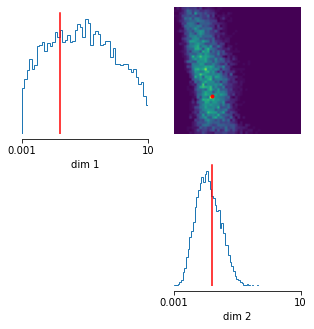

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)
/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

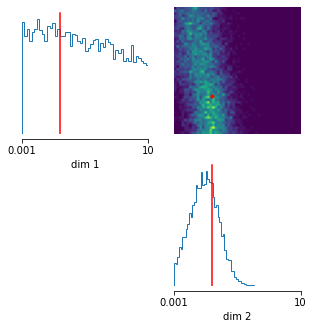

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


KeyboardInterrupt: 

In [12]:
num_rounds = 10
posteriors = []
simulator, prior = prepare_for_sbi(single_dist_sim, prior_full)
proposal = prior
inference = SNPE(prior=prior)
for i in range(1, num_rounds+1):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=8192, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel(inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.tensor([0]))
    if (i-1)%4 == 0:
        samples = posterior.sample((10000,))
        fig, axes = analysis.pairplot(samples,
                                limits=[[1e-3,10.], [1e-3,10.]],
                                ticks=[[1e-3,10.], [1e-3,10.]],
                                figsize=(5,5),
                                points=torch.tensor([3,3]),
                                points_offdiag={'markersize': 6},
                                points_colors='r');
        plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

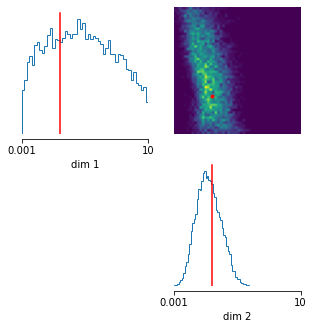

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

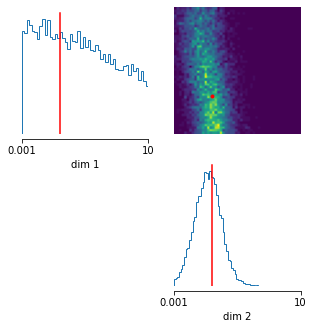

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

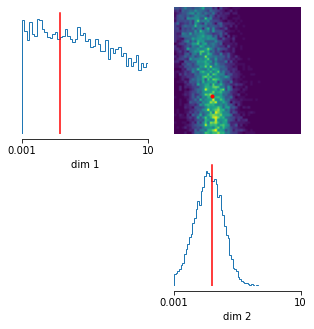

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

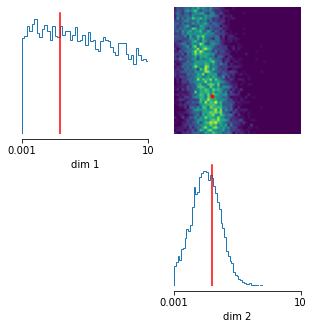

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

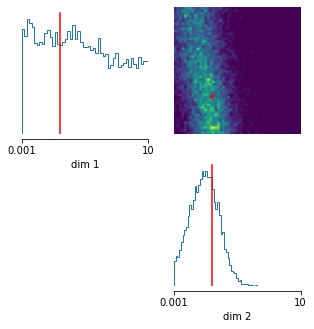

In [13]:
for posterior in posteriors:
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,10.], [1e-3,10.]],
                            ticks=[[1e-3,10.], [1e-3,10.]],
                            figsize=(5,5),
                            points=torch.tensor([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()
    

# Grid

In [14]:
def theta_grid(num_x, num_y):
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]
    y_coords = torch.linspace(prior_min[1], prior_max[1], num_y+2)[1:-1]

    return torch.cartesian_prod(x_coords, y_coords)

full_grid = theta_grid(8,8)
data = []
data.append(obs_leaves)
for theta in full_grid:
    data.append(ginkgo_simulator(theta)['leaves'])

def multi_ot_score(input, points_to_compare):
    """ This computes the optimal transport score of the input relative to the data points in 'points_to_compare'.

    Args:
        input: A tensor containing the leaves produced by ginkgo simulator.
        points_to_compare: A list of tensors containing leaves produced by ginkgo.

    Returns:
        Optimal tranpsort distances from the input to each point in points_to_compare 
    """
    distances = []
    for leaves in points_to_compare:
        distances.append(ot_dist(input,leaves))
    return torch.tensor(distances)

def grid_wrapper(params):
    input = ginkgo_simulator(params)['leaves']
    return multi_ot_score(input,data)

grid_obs = multi_ot_score(obs_leaves, data)

In [15]:
def kernel_2(xs): # Doesn't work
    
    distances = xs[:,0]
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x[:,0]**2/(var))
    
    return wrapped

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


 Neural network successfully converged after 71 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

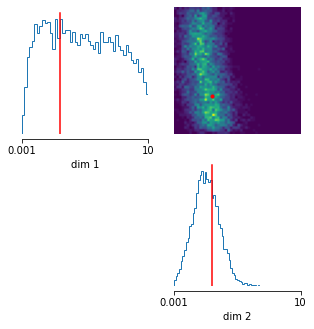

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

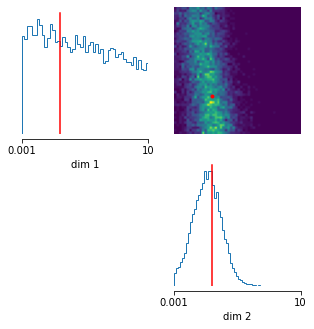

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

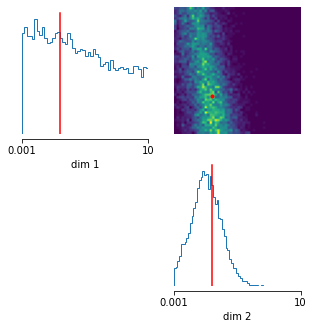

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

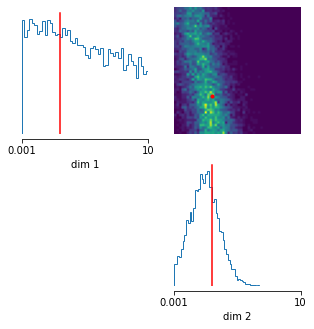

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

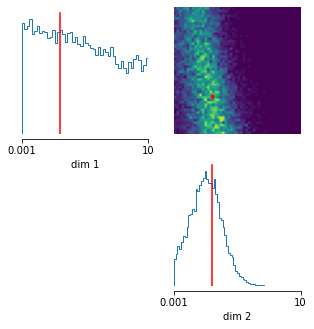

In [16]:
num_rounds = 5
posteriors_grid = []
simulator, prior = prepare_for_sbi(grid_wrapper, prior_full)
proposal = prior
inference_grid = SNPE(prior=prior)
for i in range(1, num_rounds+1):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=8192, num_workers=7)
    density_estimator = inference_grid.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel_2(inference.get_simulations()[1]))
    posterior = inference_grid.build_posterior(density_estimator)
    posteriors_grid.append(posterior)
    proposal = posterior.set_default_x(grid_obs)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,10.], [1e-3,10.]],
                            ticks=[[1e-3,10.], [1e-3,10.]],
                            figsize=(5,5),
                            points=torch.tensor([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


 Neural network successfully converged after 87 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

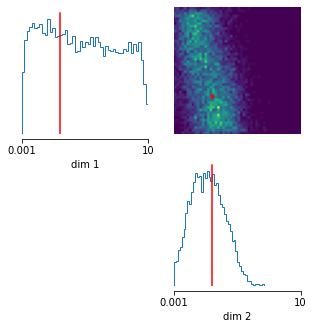

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

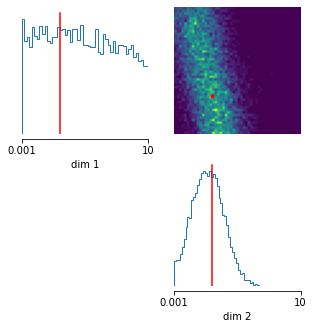

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

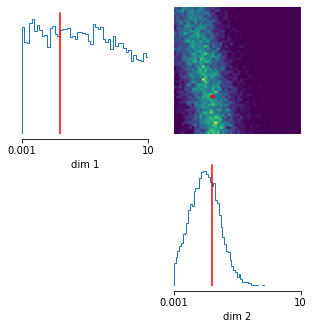

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

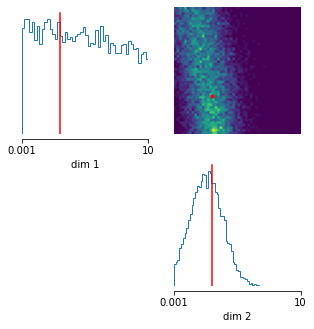

Drawing 8192 posterior samples:   0%|          | 0/8192 [00:00<?, ?it/s]

Running 8192 simulations in 8192 batches.:   0%|          | 0/8192 [00:00<?, ?it/s]

/home/sragy/anaconda3/envs/sbi/lib/python3.8/site-packages/ot/lp/__init__.py:495: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

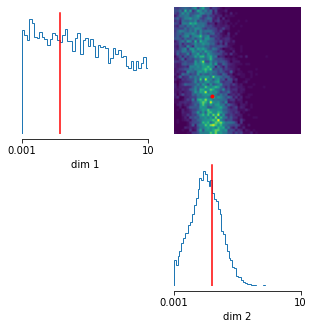

In [17]:
num_rounds = 5
posteriors_grid_2 = []
simulator, prior = prepare_for_sbi(grid_wrapper, prior_full)
proposal = prior
inference_grid_2 = SNPE(prior=prior)
for i in range(1, num_rounds+1):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=8192, num_workers=7)
    density_estimator = inference_grid_2.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference_grid_2.build_posterior(density_estimator)
    posteriors_grid_2.append(posterior)
    proposal = posterior.set_default_x(grid_obs)
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[1e-3,10.], [1e-3,10.]],
                            ticks=[[1e-3,10.], [1e-3,10.]],
                            figsize=(5,5),
                            points=torch.tensor([3,3]),
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()